# Effect of Forcings on CAMELs Simulations

Now we can look at the output and see which forcing variables have the most error for each basin. 
This code will make one figure per basin, such that you can look at the forcing error effects in each basin separately. 
In the notebook `2_camels_pysumma.ipynb` you decided if you wanted to run, in order of increasing complexity: 
 - 1)   `default_prob = 1`: the "default" configuration with the "default" parameters. By "default" we mean whatever you chose in the summa setup files. 
 - 2a) `lhs_prob = 1`: the default configuration with exploration of the parameter space.
 - 2b) `config_prob = 1`: the default parameters with different configurations.
 - 3)   `lhs_config_prob = 1`: the exploration of the parameter space with different configurations.


<br>

### Make problem complexity choices here:
In this notebook, you can only choose one choice as 1. We suggest you choose the most complex problem you ran. 
DO NOT choose one of these to be one here if you did not choose it or a more complex option to equal 1 before.

You also need to choose how long the initialization period is. We suggest you run the error computations on at least 1 year of simulation, so for example, if you ran 18 months in the previous notebook you should choose your initialization. If you only ran the previous notebook in `debug = 1` mode, this will run with an initialization period of 0 days (but the plots would be uninformative). 

Lastly, you need to know what you had as the number of LHS runs in the previous notebook if you ran that (pre-populated is `numl = 10` in cell 21 of 2_camels_pysumma.ipynb) and the default configuration (see `print(s.decisions)` output of cell 33 in 2_camels_pysumma.ipynb).

In [1]:
# This will only let one variable equal 1
default_prob = 0
lhs_prob = 0
config_prob = 0
lhs_config_prob = 1
if lhs_config_prob==1:
    default_prob = 0
    lhs_prob = 0
    config_prob = 0
elif config_prob==1:
    default_prob = 0
    lhs_prob = 0
elif lhs_prob==1:
    default_prob = 0

In [2]:
initialization_days = 183 #pre-populated to 183 days, or 6 months, paper uses 365 days
numl = 10 #number of LHS parameter sets, this should be the same as in the previous notebook
default_con_name = '++BallBerry++lightSnow++logBelowCanopy++' #default configuration, see previous notebook

Load the imports.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

<br>
Set up the paths.

In [4]:
top_folder = os.path.join(os.getcwd(), 'summa_camels')
settings_folder = os.path.join(top_folder, 'settings')
regress_folder = os.path.join(os.getcwd(), 'regress_data')

<br>

# Summary Statistics of Error on Output
First we need to calculate KGEs on the data, and then we summarize the results by problem complexity level.
KGE means perfect agreement if it is 1, and <0 means the mean is a better guess. We use a modified KGE that avoids the amplified simulated mean divided by truth mean values when is the truth mean is small, and avoids the dependence of the KGE metric on the units of measurement. Then, we scale the KGE so that the range is 1 to -1.
If the values are identical we use KGE of 1.
At the start, we must do some bookkeeping to divide the decision set into each sub-problem of default, lhs, config, and lhs_config (if you ran a bigger problem containing more than one of these). 

In [5]:
# Get names for each set of problem complexities.
if lhs_config_prob==1: 
    suffix = '_configs_latin.nc'
    default_name = default_con_name+'0'
    lat_name = [default_name[:-1]+str(i) for i in range(0,numl+1)]
elif lhs_prob==1:
    suffix = '_latin.nc'
    default_name = '0'  
    lat_name = [str(i) for i in range(0,numl+1)]
elif config_prob==1:
    suffix = '_configs.nc'
    default_name = default_con_name
    lat_name = default_name
elif default_prob==1:
    suffix = '_hru.nc'
    default_name = 'default'
    lat_name = default_name
sim_truth = xr.open_dataset(top_folder+'/output/merged_day/NLDAStruth'+suffix)

In [6]:
# Get decision names off the files
if config_prob==1 or lhs_prob==1 or lhs_config_prob==1: decision_set = np.array(sim_truth['decision']) 
else: decision_set = np.array(['default'])

In [7]:
# Get only configuration and default param decision names, and only latin params and default configuration decision names
ndec = len(decision_set)
if config_prob==0: cfg_name = decision_set[range(0,ndec,numl+1)]
else: cfg_name = decision_set
ncfg = len(cfg_name)
if lhs_config_prob==1: cfglat_name = [c[:-1]+str(i) for i in range(0,numl+1) for c in cfg_name]
elif lhs_prob==1: cfglat_name = lat_name+[default_name]
elif config_prob==1: cfglat_name = cfg_name
elif default_prob==1: cfglat_name = default_name

<br>
Next we get the forcing and output names, and find the HRUs and their locations. 

In [8]:
# Set forcings and create dictionaries, ordered forcings and output variables to match paper
constant_vars= ['pptrate','airtemp','spechum','SWRadAtm','LWRadAtm','windspd','airpres'] 
allforcings = constant_vars+['truth']
comp_sim=['scalarInfiltration','scalarSurfaceRunoff','scalarAquiferBaseflow','scalarSoilDrainage',
          'scalarTotalSoilWat','scalarCanopyWat','scalarLatHeatTotal','scalarTotalET','scalarTotalRunoff',
          'scalarSWE','scalarRainPlusMelt','scalarSnowSublimation','scalarSenHeatTotal','scalarNetRadiation']
var_sim = np.concatenate([constant_vars, comp_sim])

In [9]:
# Get number of HRUs
attrib = xr.open_dataset(top_folder+'/settings/attributes.nc')
the_hru = np.array(attrib['hruId'])
the_hru = np.array(the_hru)

In [10]:
#get lat long for plotting purposes later on
df =  pd.read_csv(regress_folder+'/camels_topo.txt',delimiter=';')
df['hru'] = range(0,671)
xr_tmp = df.set_index(['hru']).to_xarray()
xr_tmp = xr_tmp.assign_coords(hru=xr_tmp['gauge_id'])
xr_tmp = xr_tmp.sel(hru=the_hru)
lr_attrib = xr_tmp

<br>
Now run the actual computations on KGE and keep summaries of the raw data (summed over time). 
This can take some time depending on how big of a problem you ran.
It takes about 1/100th of the time it took to run the whole problem.

In [11]:
# definitions for KGE computation, correlation with a constant (e.g. all SWE is 0) will be 0 here, not NA
def covariance(x,y,dims=None):
    return xr.dot(x-x.mean(dims), y-y.mean(dims), dims=dims) / x.count(dims)

def correlation(x,y,dims=None):#
    return (covariance(x,y,dims)) / (x.std(dims) * y.std(dims))

In [12]:
# set up xarray
summary = ['KGE','Raw']
shape = ( len(decision_set),len(the_hru), len(constant_vars),len(summary))
dims = ('decision','hru','var','summary')
coords = {'decision':decision_set,'hru': the_hru, 'var':constant_vars, 'summary':summary}
error_data = xr.Dataset(coords=coords)
for s in comp_sim:
    error_data[s] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name=s)

In [13]:
%%time
truth0_0 = sim_truth.drop_vars('hruId').load()
for v in constant_vars:
    truth = truth0_0
    truth = truth.isel(time = slice(initialization_days*24,None)) #don't include first year, 5 years
    sim = xr.open_dataset(top_folder+'/output/merged_day/NLDASconstant_' + v + suffix)
    sim = sim.drop_vars('hruId').load()
    sim = sim.isel(time = slice(initialization_days*24,None)) #don't include first year, 5 years
    r = sim.mean(dim='time') #to set up xarray since xr.dot not supported on dataset and have to do loop
    for s in var_sim:         
        r[s] = correlation(sim[s],truth[s],dims='time')
    ds = 1 - np.sqrt( np.square(r-1) 
    + np.square( sim.std(dim='time')/truth.std(dim='time') - 1) 
    + np.square( (sim.mean(dim='time') - truth.mean(dim='time'))/truth.std(dim='time') ) )
    for s in var_sim:   
        #if constant and identical, want this as 1.0 -- correlation with a constant = 0 and std dev = 0
        for h in the_hru:
            if config_prob==1 or lhs_prob==1 or lhs_config_prob==1: 
                    for d in decision_set:  
                        ss = sim[s].sel(hru=h,decision = d)
                        tt = truth[s].sel(hru=h,decision = d)
                        ds[s].loc[d,h] =ds[s].sel(hru=h,decision = d).where(np.allclose(ss,tt, atol = 1e-10)==False, other=1.0)
            else:
                ss = sim[s].sel(hru=h)
                tt = truth[s].sel(hru=h)
                ds[s].loc[h] =ds[s].sel(hru=h).where(np.allclose(ss,tt, atol = 1e-10)==False, other=1.0)

    ds = ds/(2.0-ds)
    ds0 = ds.load()
    for s in comp_sim:
        error_data[s].loc[:,:,v,'KGE']  = ds0[s]
        error_data[s].loc[:,:,v,'Raw']  = sim[s].sum(dim='time') #this is raw data, not error
    print(v)

pptrate
airtemp
spechum
SWRadAtm
LWRadAtm
windspd
airpres
CPU times: user 25.2 s, sys: 1.98 s, total: 27.2 s
Wall time: 27.3 s


<br>

Now we summarize KGE error by totals over all output variables and each output variable, and rank each constant forcing from most error to least error. Also, we summarize the raw data output by forcing and by truth data (here the hourly NLDAS data).

In [14]:
# setup summaries by simulated output variable
summ_kind = ['total','rank','raw']
shape = (len(decision_set),len(the_hru),len(allforcings),len(summ_kind))
dims = ('decision','hru','var','summary')
coords = {'decision':decision_set,'hru': the_hru, 'var': allforcings,'summary':summ_kind}
summary_data = xr.Dataset(coords=coords)
summary_data['all'] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name='all')
for s in comp_sim:
    summary_data[s] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name=s)

In [15]:
# calculate sums of KGE and ranks of worst to best forcing for error over all variables
ds = error_data.sel(summary='KGE')
ds =ds.fillna(0) # So don't add to total KGE    
ds1 = ds.loc[dict(var = constant_vars)]
ds2 = sum(d for d in ds1.data_vars.values())
summary_data['all'].loc[:,:,constant_vars,'total'] = ds2.values
summary_data['all'].loc[:,:,constant_vars,'rank'] = ds2.rank(dim='var').values
for s in comp_sim:
    summary_data[s].loc[:,:,constant_vars,'total'] = ds1[s].values
    summary_data[s].loc[:,:,constant_vars,'rank'] = ds1[s].rank(dim='var').values

In [16]:
# calculate sums of raw values over all variables for constant forcings
ds = error_data.sel(summary='Raw')
ds =ds.fillna(0) # So don't add to total KGE    
ds1 = ds.loc[dict(var = constant_vars)]
ds2 = sum(d for d in ds1.data_vars.values())
summary_data['all'].loc[:,:,constant_vars,'raw'] = ds2.values
for s in comp_sim:
    summary_data[s].loc[:,:,constant_vars,'raw'] = ds1[s].values

In [17]:
# calculate sums of raw values over all variables for truth forcing
truth = sim_truth.drop_vars('hruId').load()
truth = truth.isel(time = slice(initialization_days*24,None)) #don't include first year, 5 years
for s in comp_sim:
    summary_data[s].loc[:,:,'truth','raw']  = truth[s].sum(dim='time').values 

<br>

# Make the Plots

This will make first a summary plot for each basin you ran. Then, it will make a second set of plots that show the output variable values over the parameter space, by model configuration. Note, if you did not run the previous notebook (the pysumma runs) with `lhs_config_prob = 1`, you will not be able to make the full plots from the paper. The first plots are:
- A) Location map
- B) Output variable KGE values with default problem per constant forcing dataset
     - with default parameters **par 0** and default configuration **con default_con_name**
- C) Output variable KGE range with different problem decisions 
     - with default parameters **par 0** and default configuration **con default_con_name** and all constant forcings
     - with default parameters **par 0**, LHS parameters **par 1-numl** and default configuration **con default_con_name** and all constant forcings
     - with default parameters **par 0** and all configurations **con 1-ncfg** and all constant forcings
     - with LHS parameters **par 1-numl** and all configurations **con 1-ncfg** and all constant forcings
- D) Forcing dataset KGE range with different problem decisions
     - with default parameters **par 0** and default configuration **con default_con_name** and all constant forcings
     - with LHS parameters **par 1-numl** and default configuration **con default_con_name** and all constant forcings
     - with default parameters **par 0** and all configurations **con 1-ncfg** and all constant forcings
     - with default parameters **par 0**, LHS parameters **par 1-numl** and all configurations **con 1-ncfg** and all constant forcings
- E) Forcing dataset KGE rank counts by output variable 
    - with default parameters **par 0**, LHS parameters **par 1-numl**, and all configurations **con 1-ncfg** and all constant forcings
    - for each output variable there are **(numl+1)*ncfg rankings**
- F) Forcing dataset KGE rank counts by model configuration 
     - with default parameters **par 0**, LHS parameters **par 1-numl** and all output variables and all constant forcings
     - for each model configuration there are **(numl+1)*14 rankings** 
         - the 14 is from the number of output variables

The second plots are:
- A) Summed KGE for all forcings versus truth for each output variable by model configuration
     - with any parameter set used (default parameters **par 0** and LHS parameters **par 1-numl** if run)
- B) Summed raw hourly value over the time period (excluding model initialization period that KGE was not computed over) for truth forcing for each output variable by model configuration
     - with any parameter set used (default parameters **par 0** and LHS parameters **par 1-numl** if run)


In [18]:
col1=['blue','red','brown','pink','green','cyan','gray'] 
col2=['burlywood','purple','aquamarine','magenta']
col3 = sns.color_palette(None, ncfg)

In [19]:
# Setup plots by output variable
x = np.arange(len(comp_sim))
xtic = np.arange(0, len(comp_sim)).tolist()
xtic =[i+0.5 for i in xtic]
xtics =[str(i+1) for i in xtic]
labels = list('ABCDEFGHIJKLMN')
compsim_lab = [c[6:] for c in comp_sim]

In [20]:
# Setup plots by decision
decision_lab = ['DEFAULT','LHS','CONFIG', 'COMPREHENSIVE']
decision_used = np.array([0,1,2,3])
if lhs_prob==1: decision_used = np.array([0,1])
elif config_prob==1: decision_used = np.array([0,2])
elif default_prob==1: decision_used = np.array([0])

In [21]:
# Setup plots by forcing
z = np.arange(len(constant_vars))
ztic = np.arange(0, len(constant_vars)).tolist()
ztic =[i+0.5 for i in ztic]
ztics =[str(i+1) for i in ztic]
constvar_lab = ['ppt','tmp','hum','swr','lwr','wnd','prs']

In [22]:
# Setup plots by config, allow for a varying number of configurations
c = np.arange(len(constant_vars))
ctic = np.arange(0, ncfg)
ctic =[i+0.5 for i in ctic]
ctics =[str(i+1) for i in ctic]
labelc = [str(i) for i in range(1,ncfg+1)]
if default_prob==1 or lhs_prob==1: cfg_lab = ['default']
if config_prob==1: cfg_lab = [i[2:-2] for i in cfg_name]
if lhs_config_prob==1: cfg_lab = [i[2:-3] for i in cfg_name]

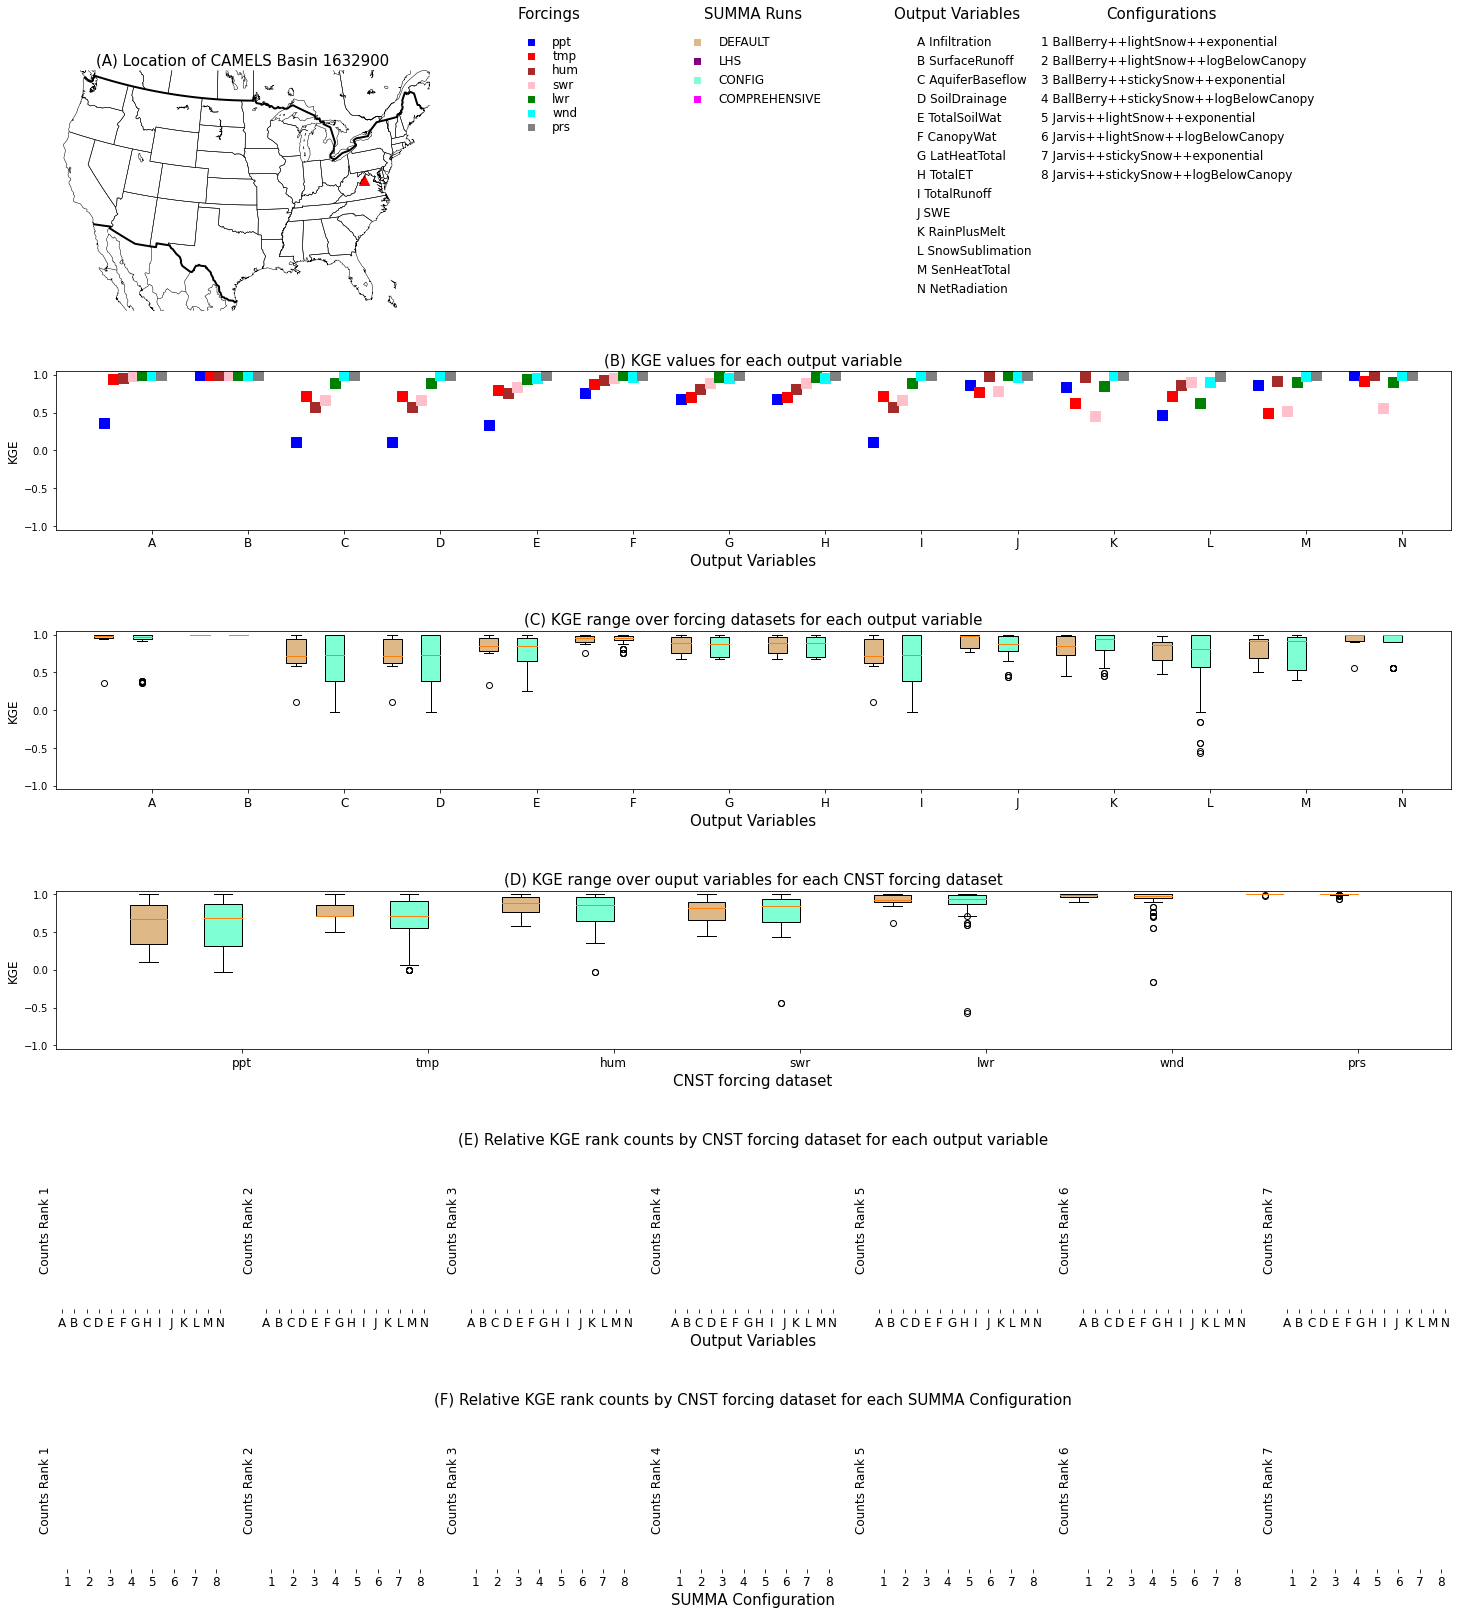

In [23]:
for h in the_hru:

    fig = plt.figure(figsize=(25, 30))

    # ------- Draw map (Plot A) ------- #
    sub1 = plt.subplot2grid((19,7), (0,0), colspan = 2, rowspan = 4)    # placing on grid

    lat=lr_attrib['gauge_lat'].sel(hru=h)
    lon=lr_attrib['gauge_lon'].sel(hru=h)
    m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',resolution='l',lat_1=33,lat_2=45,lon_0=-95)
    m.drawcoastlines(linewidth=0.5)
    m.drawstates(linewidth=0.5, linestyle='solid', color='k')
    m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
    x, y = m(lon, lat) 
    sub1.scatter(x,y,s=100, marker = '^', color='red') 
    plt.title('(A) Location of CAMELS Basin ' +str(h),fontsize = 15)
    sub1.axis("off")


    # ------- KGE values for each output variable (Plot B) ------- #
    sub2 = plt.subplot2grid((19,7), (4,0), colspan = 7, rowspan = 2)    # placing on grid

    for i, s in enumerate(comp_sim):
        data = summary_data[s].sel(hru = h,summary = 'total', decision = default_name)
        for j,v in enumerate(constant_vars):
            sub2.scatter(i+.1*j,data.sel(var = v),s=100, marker = 's', color=col1[j])

    plt.xlim(-0.5,len(comp_sim))
    plt.ylim(-1.05,1.05)
    plt.xticks(xtic, labels, fontsize = 12)
    plt.xlabel('Output Variables', fontsize = 15)
    plt.yticks(np.arange(-1.0, 1.01,0.5).tolist())
    plt.ylabel('KGE', fontsize = 12)
    plt.title('(B) KGE values for each output variable',fontsize = 15)


    # ------- KGE range over forcing datasets (Plot C) ------- #
    sub3 = plt.subplot2grid((19,7), (7,0), colspan = 7, rowspan = 2)   # placing on grid

    for i, s in enumerate(comp_sim):
        data = summary_data[s].sel(hru = h,var = constant_vars, summary = 'total')
        for j in decision_used:
            v = decision_lab[j]
            if v=='DEFAULT': data2 = data.sel(decision = default_name)
            if v=='LHS': data2 = data.sel(decision = lat_name)
            if v=='CONFIG': data2 = data.sel(decision = cfg_name)
            if v=='COMPREHENSIVE': data2 = data.sel(decision = cfglat_name)
            bp = sub3.boxplot(xr.concat(data2, dim='var'),positions = [i+.2*j],widths=0.2,patch_artist=True)
            for patch in bp['boxes']:
                patch.set(facecolor=col2[j])  

    plt.xlim(-0.5,len(comp_sim))
    plt.ylim(-1.05,1.05)
    plt.xticks(xtic, labels, fontsize = 12)
    plt.xlabel('Output Variables', fontsize = 15)
    plt.yticks(np.arange(-1.0, 1.01,0.5).tolist())
    plt.ylabel('KGE', fontsize = 12)
    plt.title('(C) KGE range over forcing datasets for each output variable',fontsize = 15)


    # ------- KGE  range over output variables  (Plot D) ------- #
    sub4 = plt.subplot2grid((19,7), (10,0), colspan = 7, rowspan = 2)  # placing on grid

    for i, s in enumerate(constant_vars):
        data = summary_data[comp_sim].sel(hru = h,var = s,summary = 'total')
        for j in decision_used:
            v = decision_lab[j]
            if v=='DEFAULT': data2 = data.sel(decision = default_name)
            if v=='LHS': data2 = data.sel(decision = lat_name)
            if v=='CONFIG': data2 = data.sel(decision = cfg_name)
            if v=='COMPREHENSIVE': data2 = data.sel(decision = cfglat_name)
            bp = sub4.boxplot(xr.concat(data2.to_array(), dim='decision'),positions = [i+.2*j],widths=0.2,patch_artist=True)
            for patch in bp['boxes']:
                patch.set(facecolor=col2[j])  

    plt.xlim(-0.5,len(constant_vars))
    plt.ylim(-1.05,1.05)
    plt.xticks(ztic, constvar_lab, fontsize = 12)
    plt.xlabel('CNST forcing dataset', fontsize = 15)
    plt.yticks(np.arange(-1.0, 1.01,0.5).tolist())
    plt.ylabel('KGE', fontsize = 12)
    plt.title('(D) KGE range over ouput variables for each CNST forcing dataset',fontsize = 15)


    # ------- Relative KGE rank counts for each output variable (Plot E) ------- # 

    for j in np.arange(len(constant_vars)):
        plot2 = plt.subplot2grid((19,7), (13,0+j), colspan = 1, rowspan = 2)  # placing on grid
        data = summary_data.sel(hru = h,summary='rank',decision = cfglat_name)
        data = data.where(data==j+1)/(j+1)
        if default_prob==0: data = data.sum(dim='decision')
        else: data = data.fillna(0)
        data = data/data.sum(dim='var')
        for i, s in enumerate(comp_sim):
            data0 = data[s]
            data_Master = 0
            for jj, v in enumerate(constant_vars):
                if lhs_config_prob==1: #only plot if ran everything
                    plt.bar(height = data0.sel(var = v), x = i+0.5, width = 0.9, color =col1[jj], bottom = data_Master)
                data_Master = data_Master+data0.sel(var = v)

        plt.xlim(-0.05,len(comp_sim)-0.05)
        plt.ylim(0,1)
        plt.xticks(xtic, labels, fontsize = 12)
        plt.yticks([], [])
        plt.box(False)
        plt.ylabel('Counts Rank '+str(j+1), fontsize = 12)

        if j==3: plt.title('(E) Relative KGE rank counts by CNST forcing dataset for each output variable',fontsize = 15)
        if j==3: plt.xlabel('Output Variables', fontsize = 15)


    # ------- Relative KGE rank counts for each configuration (Plot F) ------- # 

    for j in np.arange(len(constant_vars)):
        plot2 = plt.subplot2grid((19,7), (16,0+j), colspan = 1, rowspan = 2)  # placing on grid
        data = summary_data[comp_sim].sel(hru = h,summary='rank',decision = cfglat_name)
        data = data.where(data==j+1)/(j+1)
        for i, s in enumerate(cfg_name):
            if lhs_config_prob==1: data0 = data.sel(decision = [s[:-1]+str(k) for k in range(0,numl+1)])
            elif config_prob==1: data0 = data.sel(decision = s)
            else: data0 = data
            if lhs_prob==1 or lhs_config_prob==1: data0 = data0.sum(dim='decision')
            data0 = sum(d.fillna(0) for d in data0.data_vars.values())        
            data0 = data0/data0.sum(dim='var')    
            data_Master = 0
            #if config_prob or lhs_config_prob ==1: ii = i
            #else: ii = 3 #default configuration only
            for jj, v in enumerate(constant_vars):
                if lhs_config_prob==1 or lhs_prob==1: #only plot if ran everything for a configuration
                    plt.bar(height = data0.sel(var = v), x = i+0.5, width = 0.9, color =col1[jj], bottom = data_Master)
                data_Master = data_Master+data0.sel(var = v)

        plt.xlim(-0.05,len(cfg_name)-0.05)
        plt.ylim(0,1)
        plt.xticks(ctic, labelc, fontsize = 12)
        plt.yticks([], [])
        plt.box(False)
        plt.ylabel('Counts Rank '+str(j+1), fontsize = 12)

        if j==3: plt.title('(F) Relative KGE rank counts by CNST forcing dataset for each SUMMA Configuration',fontsize = 15)
        if j==3: plt.xlabel('SUMMA Configuration', fontsize = 15)

            
    # ------- Places the Legends ------- # 
    leg1 = plt.subplot2grid((19,7), (0,2))     # Plot B legend
    for i,s in enumerate(constvar_lab): plt.scatter([],[], color = col1[i], marker = 's', label = s)
    plt.axis('off')
    plt.title('Forcings',fontsize = 15)
    plt.legend(loc = 'upper center', prop = {'size':12}, frameon = False, labelspacing = .1)

    leg2 = plt.subplot2grid((19,7), (0,3))     # Plot C and D legend
    for i,s in enumerate(decision_lab): plt.scatter([],[], color = col2[i], marker = 's', label = s)
    plt.axis('off')
    plt.title('SUMMA Runs',fontsize = 15)
    plt.legend(loc = ('upper center'), prop = {'size':12}, frameon = False)

    leg3 = plt.subplot2grid((19,7), (0,4))     # Plot B, C, and E legend
    for i,s in enumerate(compsim_lab): plt.scatter([],[], color = 'black', marker ='', label = labels[i]+' '+s)
    plt.axis('off')
    plt.title('Output Variables',fontsize = 15)
    plt.legend(loc = ('upper center'), prop = {'size':12}, frameon = False)

    leg4 = plt.subplot2grid((19,7), (0,5))     # Plot F legend
    for i,s in enumerate(cfg_lab): plt.scatter([],[], color = 'black', marker = '', label = labelc[i]+' '+s)
    plt.axis('off')
    plt.title('Configurations',fontsize = 15)
    plt.legend(loc = ('upper center'), prop = {'size':12}, frameon = False)

    
    # ------- Prints the plot ------- #
    # if you want to save as a png
    plt.savefig('KGE_summaryBasin_'+str(h)+'.png', bbox_inches = 'tight')
    plt.show()

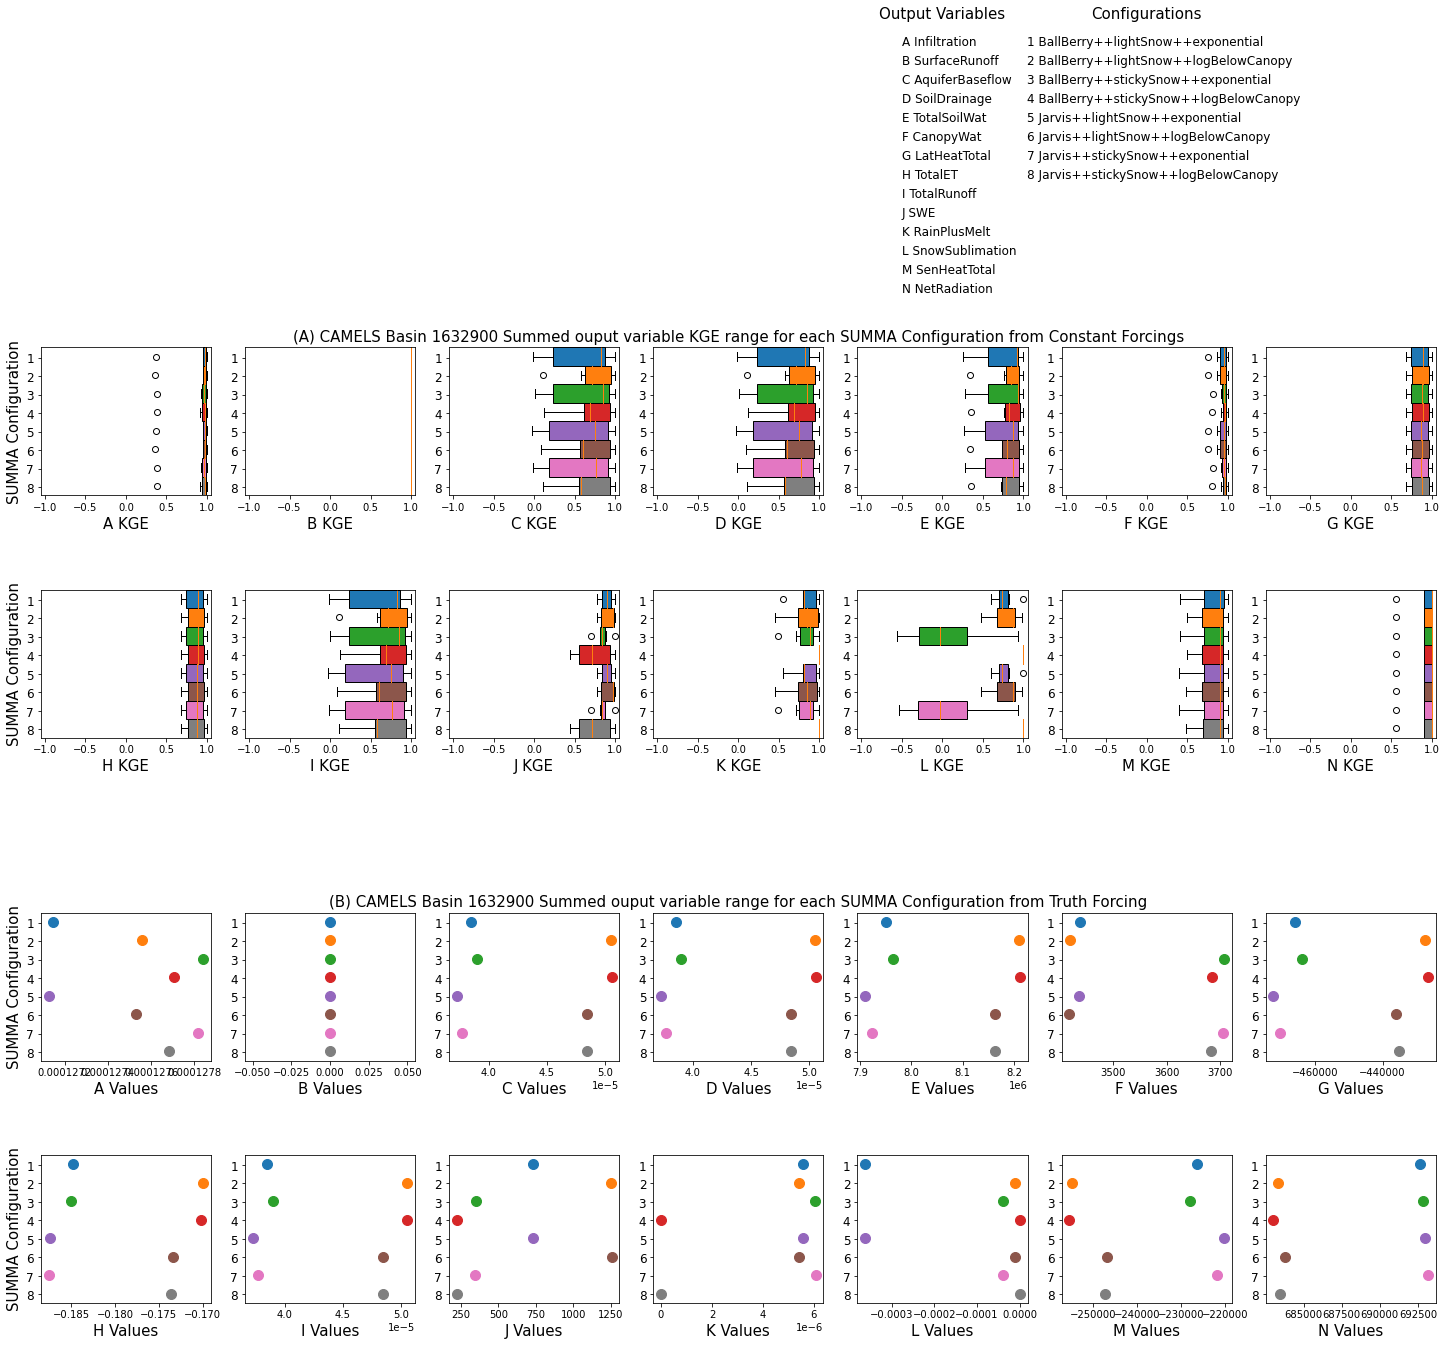

In [24]:
plot_raw_or_total = ['total','raw']
for h in the_hru:

    fig = plt.figure(figsize=(25, 25))

    for j, n in enumerate(comp_sim):
        for p, plot_type in enumerate(plot_raw_or_total):
        # ------- Value range over ouput variables by configuration ------- #
            if (j<7): plot1 = plt.subplot2grid((17,7), (4+p*7,0+j), colspan = 1, rowspan = 2)  # placing on grid
            if (j>6): plot1 = plt.subplot2grid((17,7), (7+p*7,j-7), colspan = 1, rowspan = 2)  # placing on grid
              
            if plot_type=='total': data = summary_data[n].sel(hru = h,decision = cfglat_name,var = constant_vars, summary = plot_type)
            if plot_type=='raw': data = summary_data[n].sel(hru = h,decision = cfglat_name,var = 'truth',summary = plot_type)

            
            for i, s in enumerate(cfg_name):
                if lhs_config_prob==1: data0 = data.sel(decision = [s[:-1]+str(k) for k in range(0,numl+1)])
                elif config_prob==1: data0 = data.sel(decision = s)
                else: data0 = data

                if plot_type=='raw' and (config_prob==1 or default_prob==1): #only points no box
                    bp = plot1.scatter(data0.values,i+0.45,s=100, marker = 'o',color = col3[i])     
                else: 
                    bp = plot1.boxplot(xr.concat(data0, dim='var'),widths=1,positions = [i+0.45],patch_artist=True,vert=False)
                    for patch in bp['boxes']:
                        patch.set(facecolor=col3[i])  

            plt.ylim(len(cfg_name)-0.05,-0.05)
            plt.yticks(ctic, labelc, fontsize = 12)
            if plot_type=='total': 
                plt.xlabel(labels[j]+' KGE', fontsize = 15) 
                plt.xlim(-1.05,1.05)
                plt.xticks(np.arange(-1.0, 1.01,0.5).tolist())
            if plot_type=='raw': plt.xlabel(labels[j]+' Values', fontsize = 15) #units are sums over time period

            if j==3 and plot_type=='total': plt.title('(A) CAMELS Basin ' +str(h) +' Summed ouput variable KGE range for each SUMMA Configuration from Constant Forcings',fontsize = 15)
            if j==3 and plot_type=='raw': plt.title('(B) CAMELS Basin ' +str(h) +' Summed ouput variable range for each SUMMA Configuration from Truth Forcing',fontsize = 15)
            if j==0 or j==7: plt.ylabel('SUMMA Configuration', fontsize = 15)
            if plot_type=='raw': plt.xlabel(labels[j]+' Values', fontsize = 15)
        
    # ------- Places the Legends ------- # 

    leg3 = plt.subplot2grid((17,7), (0,4))     # Output variable legend
    for i,s in enumerate(compsim_lab): plt.scatter([],[], color = 'black', marker ='', label = labels[i]+' '+s)
    plt.axis('off')
    plt.title('Output Variables',fontsize = 15)
    plt.legend(loc = ('upper center'), prop = {'size':12}, frameon = False)

    leg4 = plt.subplot2grid((17,7), (0,5))     # Configuration legend
    for i,s in enumerate(cfg_lab): plt.scatter([],[], color = 'black', marker = '', label = labelc[i]+' '+s)
    plt.axis('off')
    plt.title('Configurations',fontsize = 15)
    plt.legend(loc = ('upper center'), prop = {'size':12}, frameon = False)

    
    # ------- Prints the plot ------- #
    # if you want to save as a png
    plt.savefig('Config_summaryBasin_'+str(h)+'.png', bbox_inches = 'tight')
    plt.show()